# Latent Space Variational Geologic  Inversion from Multi-Source Dynamic Data
### Misael M. Morales, 2025
***

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import time
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist

import keras
import tensorflow as tf
import keras.backend as K
from keras import Model, Input
from keras.layers import Dense, EinsumDense, Conv2D, SeparableConv2D, LSTM
from keras.layers import Activation, PReLU, LeakyReLU
from keras.layers import BatchNormalization, GroupNormalization, LayerNormalization
from keras.layers import AveragePooling2D, MaxPooling2D, UpSampling2D
from keras.layers import Flatten, Reshape, Concatenate, Lambda, RepeatVector, TimeDistributed
from keras.optimizers import Adam, AdamW
from keras.losses import MeanSquaredError, MeanAbsoluteError, KLDivergence

def check_tf_gpu():
    sys_info = tf.sysconfig.get_build_info()
    version, cuda, cudnn = tf.__version__, sys_info["cuda_version"], sys_info["cudnn_version"]
    count = len(tf.config.experimental.list_physical_devices())
    name  = [device.name for device in tf.config.experimental.list_physical_devices('GPU')]
    print('-'*60)
    print('----------------------- VERSION INFO -----------------------')
    print('TF version: {} | # Device(s) available: {}'.format(version, count))
    print('TF Built with CUDA? {} | CUDA: {} | cuDNN: {}'.format(tf.test.is_built_with_cuda(), cuda, cudnn))
    print(tf.config.list_physical_devices()[0],'\n', tf.config.list_physical_devices()[1])
    print('-'*60+'\n')
    return None

def plot_loss(data, figsize=(6,4)):
    plt.figure(figsize=figsize)
    plt.plot(data.history['loss'], label='train')
    plt.plot(data.history['val_loss'], label='validation')
    plt.legend(); plt.grid(True, which='both')
    plt.xlabel('Epochs'); plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()
    return None

In [3]:
check_tf_gpu()

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
TF version: 2.19.0 | # Device(s) available: 2
TF Built with CUDA? True | CUDA: 12.5.1 | cuDNN: 9
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU') 
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
------------------------------------------------------------



In [4]:
nx, ny, nz = 128, 128, 1
nr, nt, nw = 1000, 40, 4

porosity = np.load('simulations_new/data/porosity.npy')
permeability = np.load('simulations_new/data/permeability.npy')
facies = np.load('simulations_new/data/facies.npy')
print('Poro: {} | Perm: {} | Facies: {}'.format(porosity.shape, permeability.shape, facies.shape))

wells = np.load('simulations_new/data/wells.npy')
timesteps = np.load('simulations_new/data/timesteps.npy')
print('Wells: {} | Timesteps: {}'.format(wells.shape, timesteps.shape))

pressure = np.load('simulations_new/data/pressure.npy')
saturation = np.load('simulations_new/data/saturation.npy')
print('Pressure: {} | Saturation: {}'.format(pressure.shape, saturation.shape))

inj_loc = np.array([[63],[63]])
prod_loc = np.array([[0,0,127,127],[0,127,0,127]])

Poro: (1000, 128, 128) | Perm: (1000, 128, 128) | Facies: (1000, 128, 128)
Wells: (1000, 40, 4, 3) | Timesteps: (40,)
Pressure: (1000, 40, 128, 128) | Saturation: (1000, 40, 128, 128)


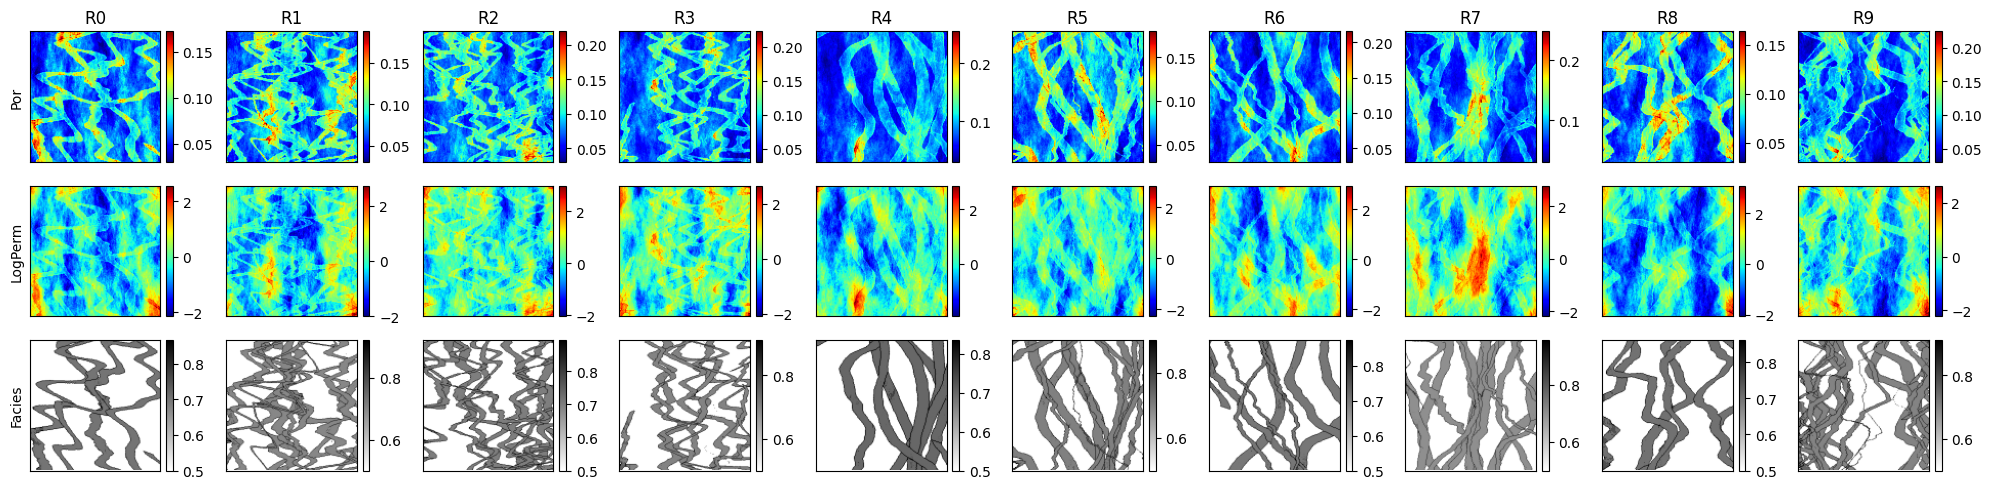

In [5]:
fig, axs = plt.subplots(3, 10, figsize=(20, 5), sharex=True, sharey=True)
for j in range(10):
    ax1, ax2, ax3 = axs[:, j]
    im1 = ax1.imshow(porosity[j], cmap='jet')
    im2 = ax2.imshow(permeability[j], cmap='jet')
    im3 = ax3.imshow(facies[j], cmap='binary')
    ax1.set_title('R{}'.format(j))
    [a.set(xticks=[], yticks=[]) for a in axs[:, j]]
    [a.set_ylabel(['Por','LogPerm','Facies'][i]) for i, a in enumerate([ax1, ax2, ax3]) if j==0]
    [plt.colorbar(im, ax=a, pad=0.04, fraction=0.046) for a, im in zip(axs[:, j], [im1, im2, im3])]
plt.tight_layout()
plt.show()

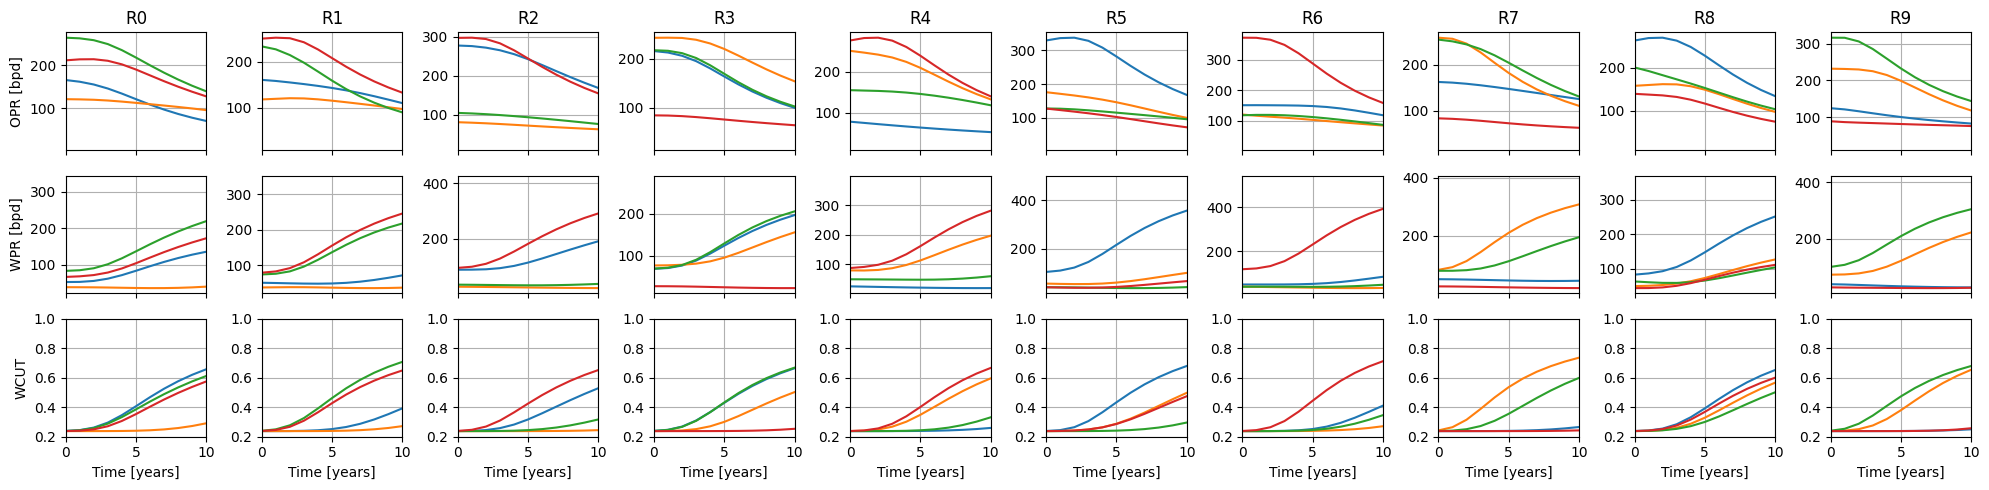

In [6]:
fig, axs = plt.subplots(3, 10, figsize=(20,5), sharex=True)
for j in range(10):
    ax1, ax2, ax3 = axs[:, j]
    ax1.plot(wells[j,:,:,0])
    ax2.plot(wells[j,:,:,1])
    ax3.plot(wells[j,:,:,2])
    [a.grid(True, which='both') for a in axs[:, j]]
    [a.set_xlim(0,10) for a in axs[:,j]]
    ax3.set(ylim=(0.2,1))
    ax3.set(xlabel='Time [years]')
    ax1.set_title('R{}'.format(j))
    [a.set_ylabel(['OPR [bpd]','WPR [bpd]','WCUT'][i]) for i, a in enumerate([ax1, ax2, ax3]) if j==0]

plt.tight_layout()
plt.show()

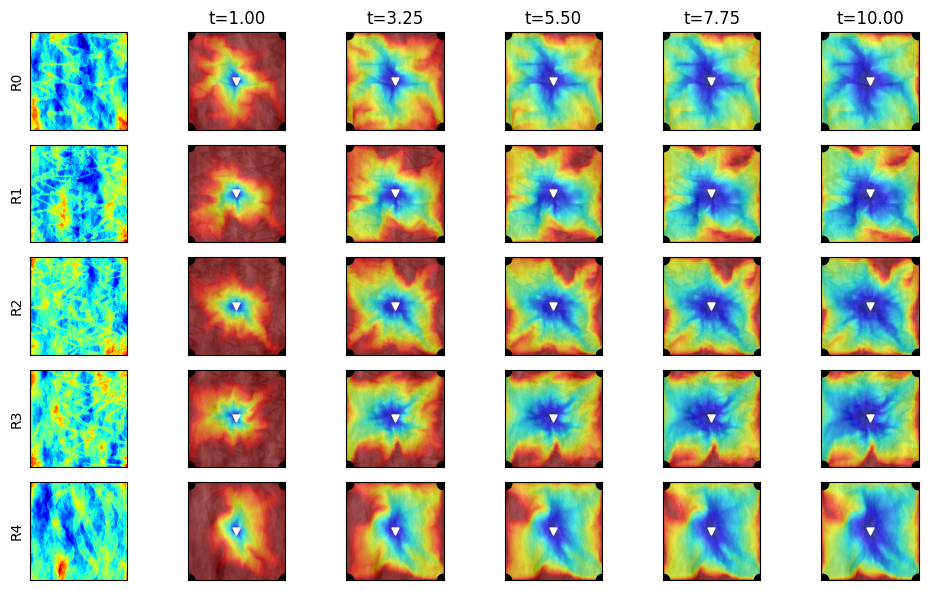

In [9]:
fig, axs = plt.subplots(5, 6, figsize=(10, 6), sharex=True, sharey=True)
for i in range(5):
    axs[i,0].imshow(permeability[i], cmap='jet')
    axs[i,0].set_ylabel('R{}'.format(i))

    for j in range(1,6):
        p = (j-1) * 9 + 3
        ax = axs[i,j]
        ax.imshow(permeability[i], cmap='binary')
        ax.imshow(saturation[i,p], cmap='jet', alpha=0.66)
        ax.scatter(inj_loc[0], inj_loc[1], c='w', marker='v', s=25)
        ax.scatter(prod_loc[0], prod_loc[1], c='k', marker='o', s=80)
        ax.set_title('t={:.2f}'.format(timesteps[p])) if i==0 else None
    
    for j in range(6):
        axs[i,j].set(xticks=[], yticks=[])

plt.tight_layout()
plt.show()

In [11]:
def make_observation_index(nobs:int=20, equigrid:bool=False, nx=128, ny=128):
    if equigrid:
        assert np.sqrt(nobs).is_integer(), 'Number of observations must be a perfect square for equigrid'
        eq_obs = int(np.sqrt(nobs))
        x = np.linspace(eq_obs, nx-1-(eq_obs), eq_obs)
        y = np.linspace(eq_obs, ny-1-(eq_obs), eq_obs)
        xx, yy = np.meshgrid(x, y)
        return np.array([xx.flatten(), yy.flatten()], dtype=int).T
    else:
        randx = np.random.choice(range(nx), nobs, replace=False)
        randy = np.random.choice(range(ny), nobs, replace=False)
        return np.array([randx, randy], dtype=int).T

In [44]:
id_obs = make_observation_index(nobs=49, equigrid=False)
id_dist = np.repeat(np.expand_dims(np.expand_dims(np.moveaxis(np.repeat(cdist(id_obs, inj_loc.T, metric='euclidean'), 40, axis=1), -1, 0), -1), 0), 1000, 0)
id_dist = ((id_dist - id_dist.min()) / (id_dist.max() - id_dist.min())) * 2 - 1

X_data = np.concatenate([np.expand_dims(saturation[...,id_obs[:,0],id_obs[:,1]],-1), 
                         np.expand_dims(pressure[...,:,id_obs[:,0],id_obs[:,1]],-1)], -1)
print('X_data: {}'.format(X_data.shape))

x1 = MinMaxScaler().fit_transform(X_data[...,0].reshape(nr,-1)).reshape(nr, nt, -1, 1)
x2 = MinMaxScaler().fit_transform(X_data[...,1].reshape(nr,-1)).reshape(nr, nt, -1, 1)
X_norm = np.concatenate([x1, x2], -1)
print('X_norm: {} | min={:.2f} | max={:.2f}'.format(X_norm.shape, X_norm.min(), X_norm.max()))

X_data: (1000, 40, 49, 2)
X_norm: (1000, 40, 49, 2) | min=0.00 | max=1.00


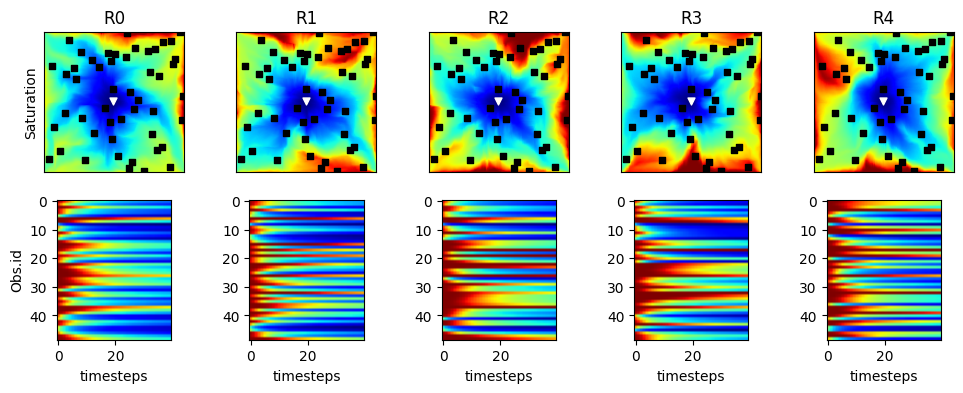

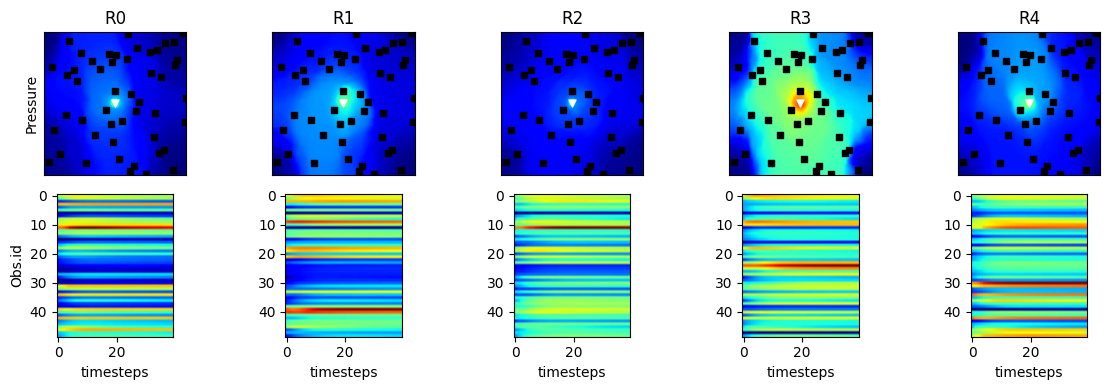

In [45]:
for k in range(2):
    data = [saturation, pressure][k]
    fig, axs = plt.subplots(2, 5, figsize=(12, 4))
    for j in range(5):
        ax1, ax2 = axs[:,j]
        im1 = ax1.imshow(data[j,-1], cmap='jet')
        ax1.scatter(inj_loc[0], inj_loc[1], c='w', marker='v', s=25)
        ax1.scatter(id_obs[:,0], id_obs[:,1], c='k', marker='s', s=20)
        im2 = ax2.imshow(X_norm[j,...,k].T, cmap='jet')
        ax1.set(xticks=[], yticks=[], ylabel=['Saturation','Pressure'][k] if j==0 else None, title='R{}'.format(j))
        ax2.set(xlabel='timesteps', ylabel='Obs.id' if j==0 else None)
plt.tight_layout()
plt.show()

In [46]:
w1 = (wells[...,0] - np.min(wells[...,0])) / (np.max(wells[...,0]) - np.min(wells[...,0]))
w2 = (wells[...,1] - np.min(wells[...,1])) / (np.max(wells[...,1]) - np.min(wells[...,1]))
w3 = (wells[...,2] - np.min(wells[...,2])) / (np.max(wells[...,2]) - np.min(wells[...,2]))
W_norm = np.concatenate([np.expand_dims(w1,-1), np.expand_dims(w2,-1), np.expand_dims(w3,-1)], -1)
print('W_norm: {} | min={:.2f} | max={:.2f}'.format(W_norm.shape, np.min(W_norm), np.max(W_norm)))

W_norm: (1000, 40, 4, 3) | min=0.00 | max=1.00


In [47]:
p = MinMaxScaler().fit_transform(porosity.reshape(nr,-1)).reshape(nr,nx,ny,1)
k = MinMaxScaler().fit_transform(permeability.reshape(nr,-1)).reshape(nr,nx,ny,1)
f = MinMaxScaler().fit_transform(facies.reshape(nr,-1)).reshape(nr,nx,ny,1)
Y_norm = np.concatenate([p, k, f], -1)
print('Y_norm: {}'.format(Y_norm.shape))
print('P: {} | min={:.2f} | max={:.2f}'.format(p.shape, p.min(), p.max()))
print('K: {} | min={:.2f} | max={:.2f}'.format(k.shape, k.min(), k.max()))
print('F: {} | min={:.2f} | max={:.2f}'.format(f.shape, f.min(), f.max()))

Y_norm: (1000, 128, 128, 3)
P: (1000, 128, 128, 1) | min=0.00 | max=1.00
K: (1000, 128, 128, 1) | min=0.00 | max=1.00
F: (1000, 128, 128, 1) | min=0.00 | max=1.00


In [48]:
train_idx = np.random.choice(range(nr), size=int(nr*0.75), replace=False)
test_idx = np.setdiff1d(range(nr), train_idx)
X_train, X_test = X_norm[train_idx], X_norm[test_idx]
W_train, W_test = W_norm[train_idx], W_norm[test_idx]
Y_train, Y_test = Y_norm[train_idx], Y_norm[test_idx]
print('X_train: {} | W_train: {} | Y_train: {}'.format(X_train.shape, W_train.shape, Y_train.shape))
print('X_test:  {} | W_test:  {} | Y_test:  {}'.format(X_test.shape, W_test.shape, Y_test.shape))

X_train: (750, 40, 49, 2) | W_train: (750, 40, 4, 3) | Y_train: (750, 128, 128, 3)
X_test:  (250, 40, 49, 2) | W_test:  (250, 40, 4, 3) | Y_test:  (250, 128, 128, 3)


***
# Model (y) AutoEncoder

In [49]:
def conv_block(inp, filt, kern=(3,3), pool=(2,2), pad='same'):
    _ = SeparableConv2D(filters=filt, kernel_size=kern, padding=pad)(inp)
    _ = SeparableConv2D(filters=filt, kernel_size=kern, padding=pad)(_)
    _ = GroupNormalization(groups=-1)(_)
    _ = BatchNormalization()(_)
    _ = Activation('gelu')(_)
    _ = AveragePooling2D(pool_size=pool)(_)
    return _

def deconv_block(inp, filt, kern=(3,3), pool=(2,2), pad='same'):
    _ = SeparableConv2D(filters=filt, kernel_size=kern, padding=pad)(inp)
    _ = SeparableConv2D(filters=filt, kernel_size=kern, padding=pad)(_)
    _ = GroupNormalization(groups=-1)(_)
    _ = BatchNormalization()(_)
    _ = Activation('gelu')(_)
    _ = UpSampling2D(size=pool)(_)
    return _

def make_static_ae(y):
    inp = Input(shape=(y.shape[1:]))
    _ = conv_block(inp, 4)
    _ = conv_block(_, 64)
    _ = conv_block(_, 128)
    code = SeparableConv2D(256, (3,3), padding='same', activation='relu')(_)
    shape_b4 = code.shape[1:]
    latent = Flatten()(code)
    shape_flat = latent.shape[1]

    z_inp = Input(shape=(shape_flat,))
    _ = Reshape((shape_b4))(z_inp)
    _ = deconv_block(_, 128)
    _ = deconv_block(_, 64)
    _ = deconv_block(_, 4)
    out = SeparableConv2D(3, (3,3), padding='same', activation='sigmoid')(_)

    enc = Model(inputs=inp, outputs=latent, name='static_encoder')
    dec = Model(inputs=z_inp, outputs=out, name='static_decoder')

    output_static = dec(enc(inp))
    ae = Model(inputs=inp, outputs=output_static, name='static_ae')
    return ae, enc, dec

In [50]:
class DualLoss(keras.Loss):
    def __init__(self, alpha=0.5):
        super(DualLoss, self).__init__()
        self.alpha = alpha
        self.mse = MeanSquaredError()

    def call(self, y_true, y_pred):
        mse_loss = self.mse(y_true, y_pred)
        ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
        return self.alpha * mse_loss + (1 - self.alpha) * ssim_loss

# of paramters: 136,230


2025-05-06 15:45:55.670747: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/dual_loss_2/SSIM/Assert/Assert
2025-05-06 15:45:55.671637: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/dual_loss_2/SSIM/Assert_1/Assert
2025-05-06 15:45:55.672285: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/dual_loss_2/SSIM/Assert_2/Assert
2025-05-06 15:45:55.672751: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/dual_loss_2/SSIM/Assert_3/Assert


Training time: 2.12 min


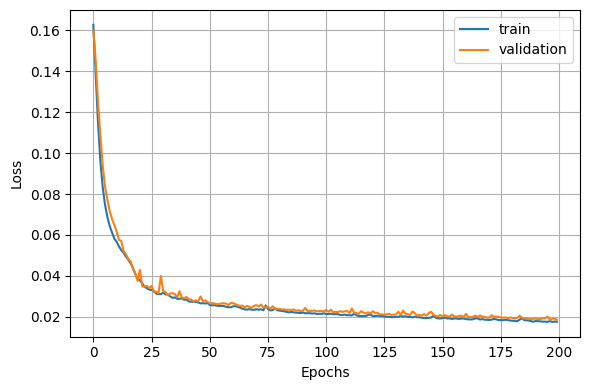

In [53]:
y_ae, y_enc, y_dec = make_static_ae(Y_train)
print('# of paramters: {:,}'.format(y_ae.count_params()))
y_ae.compile(optimizer=Adam(1e-3), metrics=['mse'], loss=DualLoss(alpha=0.9))
start = time()
y_fit = y_ae.fit(Y_train, Y_train, batch_size=16, epochs=200, verbose=0, validation_split=0.2, shuffle=True)
print('Training time: {:.2f} min'.format((time()-start)/60))
plot_loss(y_fit)

In [55]:
Y_train_pred = y_ae.predict(Y_train, verbose=0)
Y_test_pred = y_ae.predict(Y_test, verbose=0)
print('Pred - Train: {} | Test: {}'.format(Y_train_pred.shape, Y_test_pred.shape))

zy_train = y_enc.predict(Y_train, verbose=0).reshape(-1, 16, 16, 256)
zy_test = y_enc.predict(Y_test, verbose=0).reshape(-1, 16, 16, 256)
print('Latent - Train: {} | Test: {}'.format(zy_train.shape, zy_test.shape))

mse_train = np.mean(np.square(Y_train - Y_train_pred))
mse_test = np.mean(np.square(Y_test - Y_test_pred))
print('Train MSE: {:.4f} | Test MSE: {:.4f}'.format(mse_train, mse_test))

Pred - Train: (750, 128, 128, 3) | Test: (250, 128, 128, 3)
Latent - Train: (750, 16, 16, 256) | Test: (250, 16, 16, 256)
Train MSE: 0.0026 | Test MSE: 0.0033


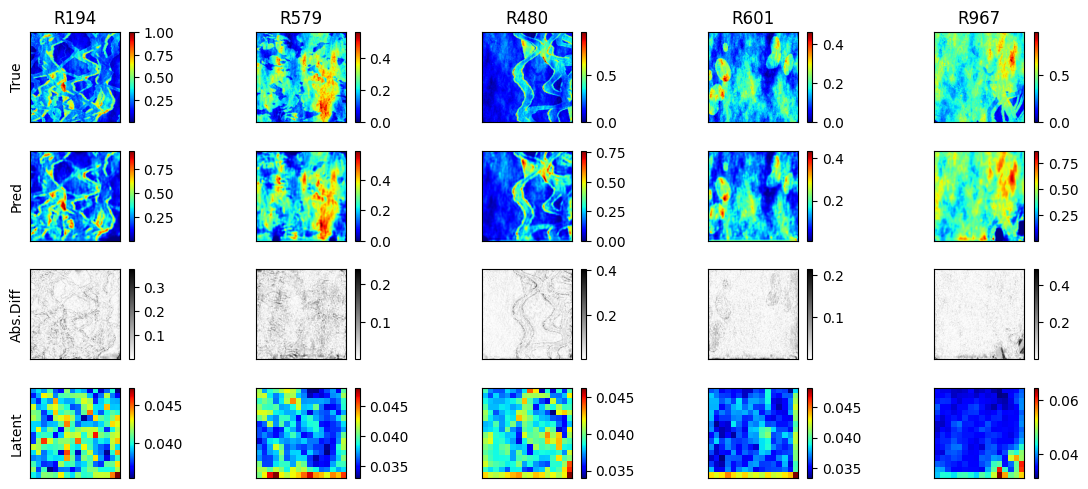

In [56]:
show_channel = 0
mult = 41

fig, axs = plt.subplots(4, 5, figsize=(12,5))
for j in range(5):
    k = j * mult
    ax1, ax2, ax3, ax4 = axs[:, j]
    true, pred = Y_train[k,...,show_channel], Y_train_pred[k,...,show_channel]
    diff = np.abs(true-pred)
    im1 = ax1.imshow(true, cmap='jet')
    im2 = ax2.imshow(pred, cmap='jet')
    im3 = ax3.imshow(diff, cmap='binary')
    im4 = ax4.imshow(zy_train[k].mean(-1), cmap='jet')
    ax1.set_title('R{}'.format(train_idx[k]))
    [a.set(xticks=[], yticks=[]) for a in axs[:, j]]
    [a.set_ylabel(['True','Pred','Abs.Diff','Latent'][i]) for i, a in enumerate([ax1, ax2, ax3, ax4]) if j==0]
    [plt.colorbar(im, ax=a, pad=0.04, fraction=0.046) for a, im in zip(axs[:, j], [im1, im2, im3, im4])]
plt.tight_layout()
plt.show()

***
# Data (X) AutoEncoder

In [61]:
def make_data_ae(x, code_dim:int=512, z_dim:int=256):
    def dense_block(inp, units):
        _ = Dense(units)(inp)
        _ = PReLU()(_)
        return _

    inputs = Input(shape=(x.shape[1:]))
    _ = Flatten()(inputs)
    _ = dense_block(_, code_dim)
    _ = dense_block(_, int((code_dim + z_dim)/2))
    code = dense_block(_, z_dim)

    z_inp = Input(shape=(z_dim,))
    _ = dense_block(z_inp, int((code_dim + z_dim)/2))
    _ = dense_block(_, code_dim)
    _ = dense_block(_, np.prod(x.shape[1:]))
    out = Reshape(x.shape[1:])(_)

    enc = Model(inputs=inputs, outputs=code, name='data_encoder')
    dec = Model(inputs=z_inp, outputs=out, name='data_decoder')
    output_data = dec(enc(inputs))
    ae = Model(inputs=inputs, outputs=output_data, name='data_ae')

    return ae, enc, dec

# of paramters: 4,615,840
Training time: 0.41 min


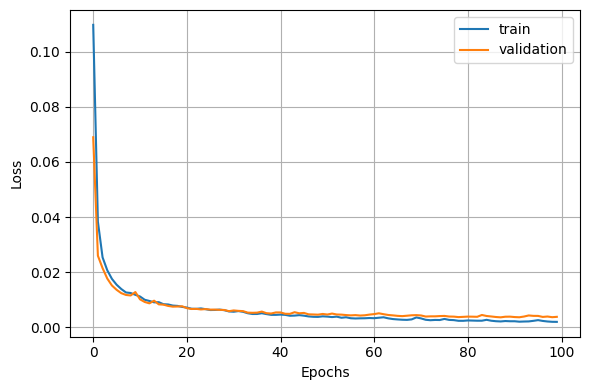

In [62]:
x_ae, x_enc, x_dec = make_data_ae(X_train)
print('# of paramters: {:,}'.format(x_ae.count_params()))
x_ae.compile(optimizer=Adam(1e-3), metrics=['mse'], loss='mse')
start = time()
x_fit = x_ae.fit(X_train, X_train, batch_size=16, epochs=100, verbose=0, validation_split=0.2, shuffle=True)
print('Training time: {:.2f} min'.format((time()-start)/60))
plot_loss(x_fit)

In [64]:
X_train_pred = x_ae.predict(X_train, verbose=0)
X_test_pred = x_ae.predict(X_test, verbose=0)
print('Pred - Train: {} | Test: {}'.format(X_train_pred.shape, X_test_pred.shape))

zx_train = x_enc.predict(X_train, verbose=0).reshape(X_train.shape[0], 16, 16)
zx_test = x_enc.predict(X_test, verbose=0).reshape(X_test.shape[0], 16, 16)
print('Latent - Train: {} | Test: {}'.format(zx_train.shape, zx_test.shape))

mse_train = np.mean(np.square(X_train - X_train_pred))
mse_test = np.mean(np.square(X_test - X_test_pred))
print('Train MSE: {:.4f} | Test MSE: {:.4f}'.format(mse_train, mse_test))

Pred - Train: (750, 40, 49, 2) | Test: (250, 40, 49, 2)
Latent - Train: (750, 16, 16) | Test: (250, 16, 16)
Train MSE: 0.0023 | Test MSE: 0.0042


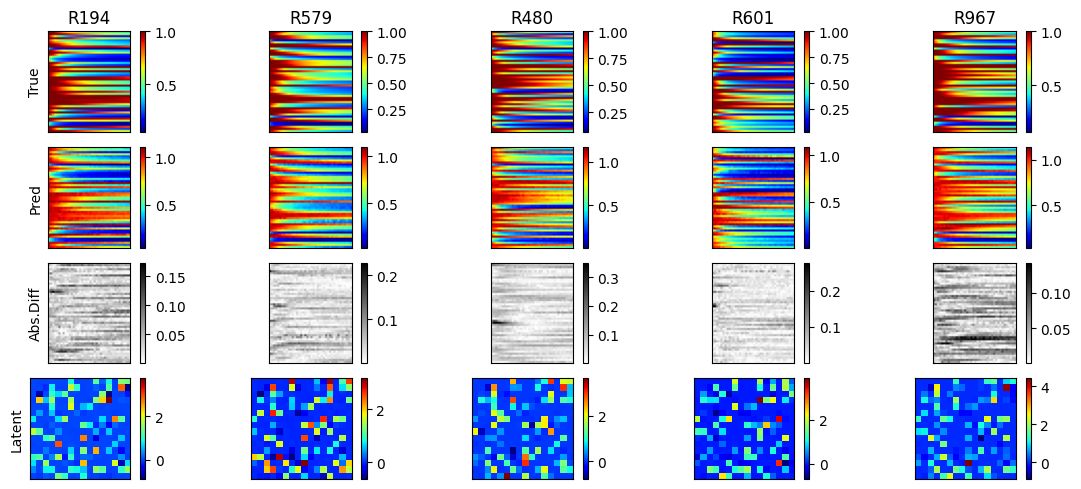

In [ ]:
show_channel = 0
mult = 41

fig, axs = plt.subplots(4, 5, figsize=(12,5))
for j in range(5):
    k = j * mult
    ax1, ax2, ax3, ax4 = axs[:, j]
    true, pred = X_train[k,...,show_channel].T, X_train_pred[k,...,show_channel].T
    diff = np.abs(true-pred)
    im1 = ax1.imshow(true, cmap='jet', vmin=0, vmax=1)
    im2 = ax2.imshow(pred, cmap='jet', vmin=0, vmax=1)
    im3 = ax3.imshow(diff, cmap='binary')
    im4 = ax4.imshow(zx_train[k].T, cmap='jet')
    ax1.set_title('R{}'.format(train_idx[k]))
    [a.set(xticks=[], yticks=[]) for a in axs[:, j]]
    [a.set_ylabel(['True','Pred','Abs.Diff','Latent'][i]) for i, a in enumerate([ax1, ax2, ax3, ax4]) if j==0]
    [plt.colorbar(im, ax=a, pad=0.04, fraction=0.046) for a, im in zip(axs[:, j], [im1, im2, im3, im4])]
plt.tight_layout()
plt.show()

***
# Wells (W) AutoEncoder

In [71]:
def make_wells_ae(w, code_dim:int=512, z_dim:int=256):
    t = w.shape[1]
    k = w.shape[2]
    f = w.shape[3]

    inputs = Input(shape=(w.shape[1:]))
    ww = Reshape((t, k*f))(inputs)
    x = LSTM(code_dim, return_sequences=True)(ww)
    x = LSTM(z_dim, return_sequences=False)(x)
    code = x

    z_inp = Input(shape=(z_dim,))
    x = RepeatVector(t)(z_inp)
    x = LSTM(code_dim, return_sequences=True)(x)
    x = LSTM(f*k, return_sequences=True)(x)
    out = Reshape((t, k, f))(x)

    enc = Model(inputs=inputs, outputs=code, name='wells_encoder')
    dec = Model(inputs=z_inp, outputs=out, name='wells_decoder')
    output_data = dec(enc(inputs))
    ae = Model(inputs=inputs, outputs=output_data, name='wells_ae')
    return ae, enc, dec

# of paramters: 4,615,840
Training time: 2.78 min


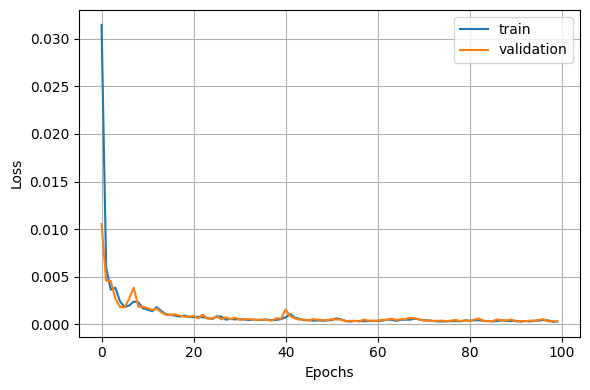

In [72]:
w_ae, w_enc, w_dec = make_wells_ae(W_train)
print('# of paramters: {:,}'.format(x_ae.count_params()))
w_ae.compile(optimizer=Adam(1e-3), metrics=['mse'], loss='mse')
start = time()
w_fit = w_ae.fit(W_train, W_train, batch_size=16, epochs=100, verbose=0, validation_split=0.2, shuffle=True)
print('Training time: {:.2f} min'.format((time()-start)/60))
plot_loss(w_fit)

In [73]:
W_train_pred = w_ae.predict(W_train, verbose=0)
W_test_pred = w_ae.predict(W_test, verbose=0)
print('Pred - Train: {} | Test: {}'.format(W_train_pred.shape, W_test_pred.shape))

zw_train = w_enc.predict(W_train, verbose=0).reshape(W_train.shape[0], 16, 16)
zw_test = w_enc.predict(W_test, verbose=0).reshape(W_test.shape[0], 16, 16)
print('Latent - Train: {} | Test: {}'.format(zw_train.shape, zw_test.shape))

mse_train = np.mean(np.square(W_train - W_train_pred))
mse_test = np.mean(np.square(W_test - W_test_pred))
print('Train MSE: {:.4f} | Test MSE: {:.4f}'.format(mse_train, mse_test))

Pred - Train: (750, 40, 4, 3) | Test: (250, 40, 4, 3)
Latent - Train: (750, 16, 16) | Test: (250, 16, 16)
Train MSE: 0.0003 | Test MSE: 0.0003


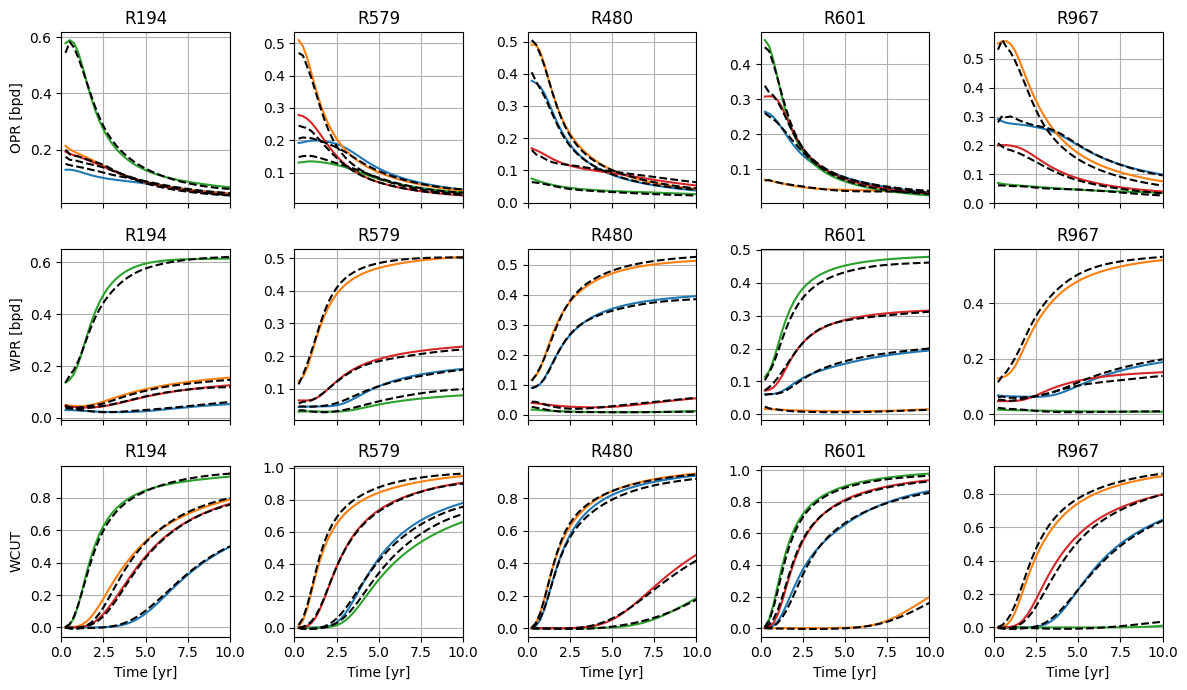

In [74]:
show_channel = 0
mult = 41

fig, axs = plt.subplots(3, 5, figsize=(12,7), sharex=True)
for i in range(3):
    for j in range(5):
        ax = axs[i,j]
        k = j * mult
        true, pred = W_train[k,...,i], W_train_pred[k,...,i]
        diff = (true-pred).mean(-1)
        ax.plot(timesteps, true, ls='-')
        ax.plot(timesteps, pred, ls='--', c='k')
        #ax.plot(timesteps, diff, ls=':', c='k')
        ax.grid(True, which='both')
        ax.set(xlabel='Time [yr]') if i==2 else None
        ax.set(xlim=(0,10), title='R{}'.format(train_idx[k]))
    axs[i,0].set_ylabel(['OPR [bpd]','WPR [bpd]','WCUT'][i])
plt.tight_layout()
plt.show()

***
# Inverse regressor

In [77]:
print('X: {} | W: {} | Y: {}'.format(zx_train.shape, zw_train.shape, zy_train.shape))

X: (750, 16, 16) | W: (750, 16, 16) | Y: (750, 16, 16, 256)


In [ ]:
def make_inv_regressor(zx, zw):
    def dense_block(inp, units):
        _ = Dense(units)(inp)
        _ = PReLU()(_)
        return _


    xinp = Input(shape=(zx.shape[1:]))   
    x = Flatten()(xinp)
    x = dense_block(x, 256)
    x = dense_block(x, 256)
    x = Reshape((x.shape[1], 1))(x)
    print(x.shape)

    winp = Input(shape=(zw.shape[1:]))
    w = Flatten()(winp)
    w = dense_block(w, 256)
    w = dense_block(w, 256)
    w = Reshape((w.shape[1], 1))(w)
    print(w.shape)

    y = tf.keras.ops.einsum('bj, bk -> bjk', x, w)
    print(y.shape)
    
    model = Model(inputs=[zx, zw], outputs=y, name='inv_regressor')
    return model

In [103]:
invreg = make_inv_regressor(X_train, W_train)
print('# of paramters: {:,}'.format(invreg.count_params()))
invreg.compile(optimizer=Adam(1e-3), metrics=['mse'], loss=DualLoss(alpha=0.9))

start = time()
invreg_fit = invreg.fit([X_train, W_train], Y_train, 
                        batch_size=16, 
                        epochs=100, 
                        verbose=0, 
                        validation_split=0.2, 
                        shuffle=True)
print('Training time: {:.2f} min'.format((time()-start)/60))
plot_loss(invreg_fit)

(None, 256, 1)
(None, 256, 1)


ValueError: Number of dimensions in the subscript does not match the number of dimensions in the operand, received subscript `bj` and operand of shape [-1, 256, 1].

In [ ]:
y_inv_train = invreg.predict([X_train, W_train], verbose=0)
y_inv_test = invreg.predict([X_test, W_test], verbose=0)
print('Inversion - Train: {} | Test: {}'.format(y_inv_train.shape, y_inv_test.shape))

mse_train = np.mean(np.square(Y_train - y_inv_train))
mse_test = np.mean(np.square(Y_test - y_inv_test))
print('Train MSE: {:.4f} | Test MSE: {:.4f}'.format(mse_train, mse_test))

In [ ]:
sample = 300

fig, axs = plt.subplots(3, 4, figsize=(15,10))

for i in range(3):
    axs[i,0].plot(timesteps, W_train[sample,...,i])
    axs[i,0].set(xlim=(0,10), xlabel='Time [yr]', ylabel=['OPR [bpd]','WPR [bpd]','WCUT'][i])
    axs[i,0].grid(True, which='both')

for i in range(2):
    axs[i,1].imshow(X_train[sample,...,i].T, cmap='jet')
    axs[i,1].set(xlabel='Timestep', ylabel='Obs.id', title=['Pressure','Saturation'][i])
axs[2,1].axis('off')

for i in range(3):
    axs[i,2].imshow(y_inv_train[sample,...,i], cmap='jet')
    axs[i,2].set(ylabel=['Porosity','LogPerm','Facies'][i], xticks=[], yticks=[])
    axs[i,2].set_title('Inverse', color='r') if i==0 else None

for i in range(3):
    axs[i,3].imshow(Y_train[sample,...,i], cmap='jet')
    axs[i,3].set(xticks=[], yticks=[])
    axs[i,3].set_title('True', color='b') if i==0 else None

plt.tight_layout()
plt.show()